In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [62]:
holiday_events = pd.read_csv("holidays_events.csv", parse_dates = ['date'])
oil = pd.read_csv("oil.csv", parse_dates = ['date'])
stores = pd.read_csv("stores.csv")
transactions = pd.read_csv("transactions.csv", parse_dates = ['date'])

# Merging all of our relevant data together into one dataset

In [63]:
# Leave out the id.
train = pd.read_csv('train.csv', usecols = [1, 2, 3, 4, 5], parse_dates = ['date'])
train['sales'] = np.log1p(train['sales'])
train

,date,store_nbr,family,sales,onpromotion
0,2013-01-01,1,AUTOMOTIVE,0.000000,0
1,2013-01-01,1,BABY CARE,0.000000,0
2,2013-01-01,1,BEAUTY,0.000000,0
3,2013-01-01,1,BEVERAGES,0.000000,0
4,2013-01-01,1,BOOKS,0.000000,0
...,...,...,...,...,...
3000883,2017-08-15,9,POULTRY,6.084802,0
3000884,2017-08-15,9,PREPARED FOODS,5.046987,1
3000885,2017-08-15,9,PRODUCE,7.791824,148
3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,4.804021,8


In [64]:
def add_store_information(data, store_information):
    # Adds information about city, state, and cluster for each store.
    return data.merge(store_information.drop(labels = ['type'], axis = 1), how = 'left', on = 'store_nbr')

train_stores = add_store_information(train, stores)
train_stores

,date,store_nbr,family,sales,onpromotion,city,state,cluster
0,2013-01-01,1,AUTOMOTIVE,0.000000,0,Quito,Pichincha,13
1,2013-01-01,1,BABY CARE,0.000000,0,Quito,Pichincha,13
2,2013-01-01,1,BEAUTY,0.000000,0,Quito,Pichincha,13
3,2013-01-01,1,BEVERAGES,0.000000,0,Quito,Pichincha,13
4,2013-01-01,1,BOOKS,0.000000,0,Quito,Pichincha,13
...,...,...,...,...,...,...,...,...
3000883,2017-08-15,9,POULTRY,6.084802,0,Quito,Pichincha,6
3000884,2017-08-15,9,PREPARED FOODS,5.046987,1,Quito,Pichincha,6
3000885,2017-08-15,9,PRODUCE,7.791824,148,Quito,Pichincha,6
3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,4.804021,8,Quito,Pichincha,6


In [65]:
# The stores are never open for Christmas (Navidad). For some forecasting algorithms, missing dates aren't allowed.
# For this reason, we create a new DataFrame for Christmas and add it to the training DataFrame
# This isn't necessary to do for the test set

# Creating Christmas DataFrame
store_numbers = pd.DataFrame({'store_nbr' : np.arange(1,55), 'one' : np.ones(54)})
families = pd.DataFrame({'family' : np.sort(train_stores['family'].unique()), 'one' : np.ones(33)})
christmas = pd.DataFrame({'date': pd.to_datetime([20131225, 20141225, 20151225, 20161225], format='%Y%m%d'), 'one' : np.ones(4)})
missing_day = christmas.merge(store_numbers, on = 'one').merge(families, on = 'one').drop(labels = ['one'], axis = 1)

# We fill in the missing values which we can put as zero.
# Unfortunately this could ruin the modeling of algorithms that don't take in covariates.
# For those, a linear estimation could be used instead and change predictions for Christmas to be zero post-modeling.
# Or, simply just only use data starting from 2017 for those models.
missing_day['sales'] = np.float64(0)
missing_day['onpromotion'] = 0

# Add the Christmas DataFrame to the training data set.
def add_christmas(data, christmas_dates):
    return pd.concat([train_stores, christmas_dates]).sort_values(['date', 'store_nbr', 'family'])

train_all_dates = add_christmas(train_stores, missing_day)
train_all_dates

,date,store_nbr,family,sales,onpromotion,city,state,cluster
0,2013-01-01,1,AUTOMOTIVE,0.000000,0,Quito,Pichincha,13.0
1,2013-01-01,1,BABY CARE,0.000000,0,Quito,Pichincha,13.0
2,2013-01-01,1,BEAUTY,0.000000,0,Quito,Pichincha,13.0
3,2013-01-01,1,BEVERAGES,0.000000,0,Quito,Pichincha,13.0
4,2013-01-01,1,BOOKS,0.000000,0,Quito,Pichincha,13.0
...,...,...,...,...,...,...,...,...
3000751,2017-08-15,54,POULTRY,4.104608,0,El Carmen,Manabi,3.0
3000752,2017-08-15,54,PREPARED FOODS,4.553877,0,El Carmen,Manabi,3.0
3000753,2017-08-15,54,PRODUCE,6.820421,76,El Carmen,Manabi,3.0
3000754,2017-08-15,54,SCHOOL AND OFFICE SUPPLIES,0.000000,0,El Carmen,Manabi,3.0


In [66]:
#Remove any events that happen only once as it's uninformative
popular_events = holiday_events[holiday_events.duplicated('description', keep = False)].drop(labels = ['type', 'transferred'], axis = 1)

#Make separate dataframes for each type of holiday based on its locale
national = (popular_events.query("locale == 'National'").drop_duplicates('date')
            .drop(labels = ['locale', 'locale_name'], axis = 1)
            .rename({'description': 'national_holiday'}, axis = 1))
local = (popular_events.query("locale == 'Local'").drop_duplicates(subset = ['date', 'locale_name'])
         .drop(labels = ['locale'], axis = 1)
         .rename({'locale_name': 'city', 'description': 'local_holiday'}, axis = 1))
regional = (popular_events.query("locale == 'Regional'")
            .drop(labels = ['locale'], axis = 1)
            .rename({'locale_name': 'state', 'description': 'regional_holiday'}, axis = 1))

#Add holidays as its own columns into the training data set
def add_holidays(data, national, local, regional):
    return ((data.merge(national, on = 'date', how = 'left')
            .merge(local, on = ['city', 'date'], how = 'left')
            .merge(regional, on = ['state', 'date'], how = 'left')).drop(labels = ['city', 'state', 'cluster'], axis = 1))

train_stores_holidays = add_holidays(train_all_dates, national, local, regional)
train_stores_holidays

,date,store_nbr,family,sales,onpromotion,national_holiday,local_holiday,regional_holiday
0,2013-01-01,1,AUTOMOTIVE,0.000000,0,Primer dia del ano,NaN,NaN
1,2013-01-01,1,BABY CARE,0.000000,0,Primer dia del ano,NaN,NaN
2,2013-01-01,1,BEAUTY,0.000000,0,Primer dia del ano,NaN,NaN
3,2013-01-01,1,BEVERAGES,0.000000,0,Primer dia del ano,NaN,NaN
4,2013-01-01,1,BOOKS,0.000000,0,Primer dia del ano,NaN,NaN
...,...,...,...,...,...,...,...,...
3008011,2017-08-15,54,POULTRY,4.104608,0,NaN,NaN,NaN
3008012,2017-08-15,54,PREPARED FOODS,4.553877,0,NaN,NaN,NaN
3008013,2017-08-15,54,PRODUCE,6.820421,76,NaN,NaN,NaN
3008014,2017-08-15,54,SCHOOL AND OFFICE SUPPLIES,0.000000,0,NaN,NaN,NaN


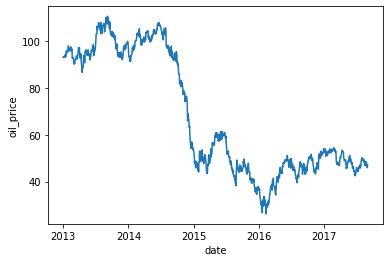

In [67]:
#Interpolate missing values using a linear estimation

oil = oil.set_index('date').asfreq('D').reset_index()
oil['oil_price'] = oil['dcoilwtico'].interpolate().fillna(93.14)
oil_updated = oil.drop(labels = ['dcoilwtico'], axis = 1)
sns.lineplot(data = oil, x = 'date', y = 'oil_price');

While we added oil prices to our DataFrame, it's important to realize here that oil prices will not be known beforehand when we are trying to make our predictions. Predicting oil prices would be another entire project on its own, and from the Social Network, allegedly oil prices can be predicted by predicting weather patterns (Eduardo Saverin)!

To combat data leakage, we can either simply not use oil prices at all in our model, or assume a constant oil price from the last day before our predictions since we are only predicting 16 days out and the price of oil is not expected to change significantly in the course of 16 days (ignoring the few exceptions). It's also possible to build a simple exponential smoothing model and use that to predict oil prices, but this may not offer any advantages.

In [68]:
#Add the oil prices to the training set

train_stores_holidays_oil = train_stores_holidays.merge(oil_updated, on = 'date', how = 'left')
train_stores_holidays_oil

,date,store_nbr,family,sales,onpromotion,national_holiday,local_holiday,regional_holiday,oil_price
0,2013-01-01,1,AUTOMOTIVE,0.000000,0,Primer dia del ano,NaN,NaN,93.14
1,2013-01-01,1,BABY CARE,0.000000,0,Primer dia del ano,NaN,NaN,93.14
2,2013-01-01,1,BEAUTY,0.000000,0,Primer dia del ano,NaN,NaN,93.14
3,2013-01-01,1,BEVERAGES,0.000000,0,Primer dia del ano,NaN,NaN,93.14
4,2013-01-01,1,BOOKS,0.000000,0,Primer dia del ano,NaN,NaN,93.14
...,...,...,...,...,...,...,...,...,...
3008011,2017-08-15,54,POULTRY,4.104608,0,NaN,NaN,NaN,47.57
3008012,2017-08-15,54,PREPARED FOODS,4.553877,0,NaN,NaN,NaN,47.57
3008013,2017-08-15,54,PRODUCE,6.820421,76,NaN,NaN,NaN,47.57
3008014,2017-08-15,54,SCHOOL AND OFFICE SUPPLIES,0.000000,0,NaN,NaN,NaN,47.57


Now we have moved all of our data into one data set! The transactions dataset shows a total transactions at each store per day, which is already captured in the sales data in our dataset. It could be helpful for visualizing the data to get an understanding trends or patterns in the data. We could get similar information by doing a groupby operation on the training data set we just created.

# Exploratory Data Analysis + Feature Engineering

We can start to visualize our dataset to get a sense of what kind of data we are looking at and if there are any obvious trends/correlations that appear. A challenge of this dataset is that it consists of 54 different stores that sell 33 different 'families' of products, giving us 1782 total timeseries. To most quickly see relationships, it would make sense to build a 3D heatmap, but unfortunately it would still be difficult the visualize. To start, we look at date trends.

In [69]:
def add_date_features(data):
    """
    Takes in a dataframe with a 'date' column.
    Returns the dataframe with new features (year, month, day of week, day of month) as individual columns.
    """
    with_date = data.copy()
    with_date['year'] = with_date['date'].dt.year
    with_date['month'] = with_date['date'].dt.month
    with_date['day_week'] = with_date['date'].dt.dayofweek
    with_date['day'] = with_date['date'].dt.day
    return with_date

with_date = add_date_features(train_stores_holidays)
with_date

,date,store_nbr,family,sales,onpromotion,national_holiday,local_holiday,regional_holiday,year,month,day_week,day
0,2013-01-01,1,AUTOMOTIVE,0.000000,0,Primer dia del ano,NaN,NaN,2013,1,1,1
1,2013-01-01,1,BABY CARE,0.000000,0,Primer dia del ano,NaN,NaN,2013,1,1,1
2,2013-01-01,1,BEAUTY,0.000000,0,Primer dia del ano,NaN,NaN,2013,1,1,1
3,2013-01-01,1,BEVERAGES,0.000000,0,Primer dia del ano,NaN,NaN,2013,1,1,1
4,2013-01-01,1,BOOKS,0.000000,0,Primer dia del ano,NaN,NaN,2013,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
3008011,2017-08-15,54,POULTRY,4.104608,0,NaN,NaN,NaN,2017,8,1,15
3008012,2017-08-15,54,PREPARED FOODS,4.553877,0,NaN,NaN,NaN,2017,8,1,15
3008013,2017-08-15,54,PRODUCE,6.820421,76,NaN,NaN,NaN,2017,8,1,15
3008014,2017-08-15,54,SCHOOL AND OFFICE SUPPLIES,0.000000,0,NaN,NaN,NaN,2017,8,1,15


Two random stores with random families were chosen to visualize below. In one case, the data is very periodic with sharp jumps, while in the other case, the data seems to be quite steady with some noise.

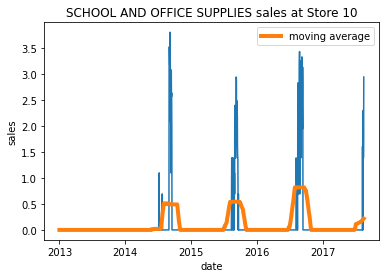

In [70]:
def visualize_data_store_family(data, store, family, span=0):
    auto1 = data.query(f"(store_nbr == {store}) and (family == '{family}')")[['date', 'sales']][-span:]
    auto1['rolling'] = auto1['sales'].rolling(window = 90, center = True, min_periods = 1).mean()
    sns.lineplot(data = auto1, x = 'date', y = 'sales')
    sns.lineplot(data = auto1, x = 'date', y = 'rolling', label = 'moving average', lw = 4)
    plt.title(f"{family} sales at Store {store}");

visualize_data_store_family(with_date, 10, 'SCHOOL AND OFFICE SUPPLIES')

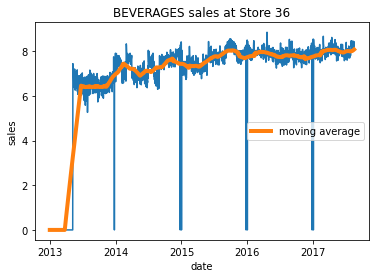

In [71]:
visualize_data_store_family(with_date, 36, 'BEVERAGES')

We can also take a look to see if there is any dependence of sales on the day of the week or on the month of the year. In general, it seems that the weekend has larger sales (slightly) and that december also has the largest sales. Also in general, the total number of sales goes up every year (either due to inflation or more stores or actually selling more). 

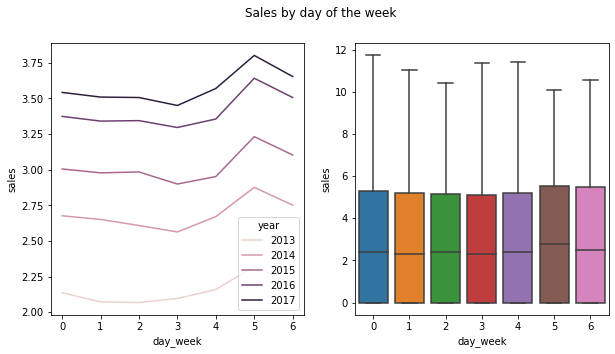

In [72]:
fig, ax = plt.subplots(1,2, figsize = (10, 5))
sns.lineplot(data = with_date[['year', 'day_week', 'sales']].groupby(['year', 'day_week']).agg(np.mean), x = 'day_week', y = 'sales', hue = 'year', ax = ax[0])
sns.boxplot(data = with_date[['day_week', 'sales']], x = 'day_week', y = 'sales')
fig.suptitle('Sales by day of the week');

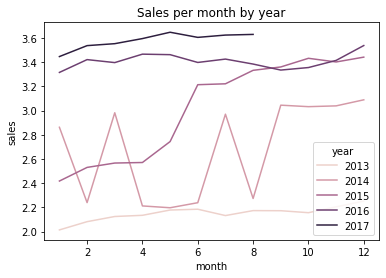

In [73]:
sns.lineplot(data = with_date[['year', 'month', 'sales']].groupby(['year', 'month']).agg(np.mean),
             x = 'month',
             y = 'sales',
             hue = 'year');
plt.title('Sales per month by year');

Based on the oil prices shown above, oil prices tended to have fluctuated around two averages (50 and 100) in the past four years. This is shown by the clusters in the scatterplot.

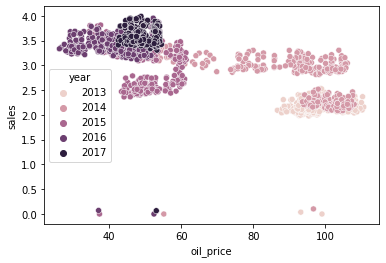

In [74]:
with_oil = add_date_features(train_stores_holidays_oil[['date', 'sales', 'oil_price']].groupby('date').agg(np.mean).reset_index())
sns.scatterplot(data = with_oil, x = "oil_price", y = "sales", hue = 'year');

We can also attempt to look to see if there is a correlation between the sales of different stores and/or families. In the case we wanted to build a global model, the store number/location/cluster can be used as static covariates to help improve the model. While we will not be doing that due to the sheer size of the dataset and the complexity of the models that involve using these static covaritates (and my poor laptop), it is a good exercise.

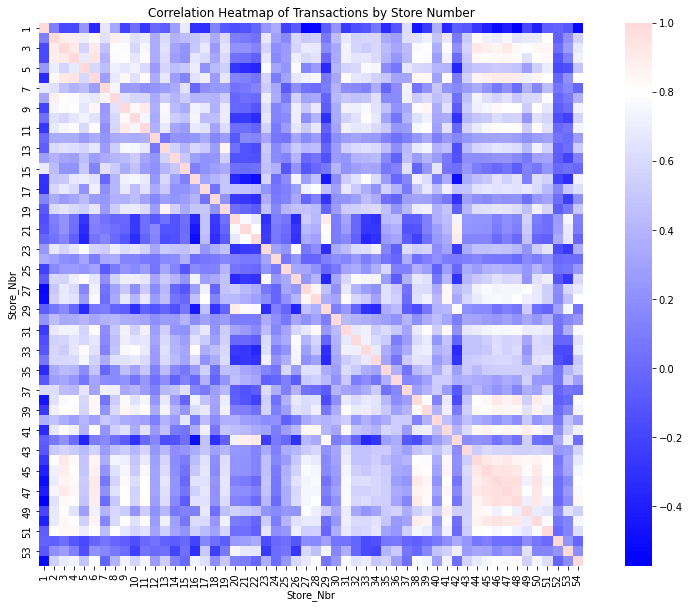

In [75]:
# Correlation between different stores

pivoted_tra = transactions.pivot(index = 'date', columns = 'store_nbr', values = 'transactions').iloc[1:].fillna(0)
pivoted_tra

plt.figure(figsize=(15,10))
sns.heatmap(pivoted_tra.corr(), square = True, center = 0.8, cmap = "bwr");
plt.title("Correlation Heatmap of Transactions by Store Number")
plt.xlabel("Store_Nbr")
plt.ylabel("Store_Nbr");

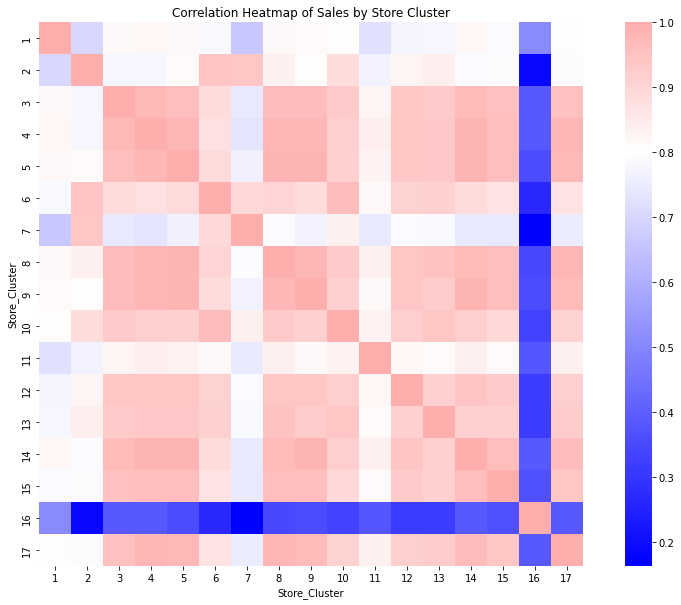

In [76]:
# Correlation between different clusters
cluster_information = (train_stores[['date', 'cluster', 'sales']].groupby(['date','cluster'])
                       .agg(sum)
                       .reset_index()
                       .pivot(index = 'date', columns = 'cluster', values = 'sales')
                       .iloc[1:].fillna(0))

plt.figure(figsize=(15,10))
sns.heatmap(cluster_information.corr(), square = True, center = 0.8, cmap = "bwr");
plt.title("Correlation Heatmap of Sales by Store Cluster")
plt.xlabel("Store_Cluster")
plt.ylabel("Store_Cluster");

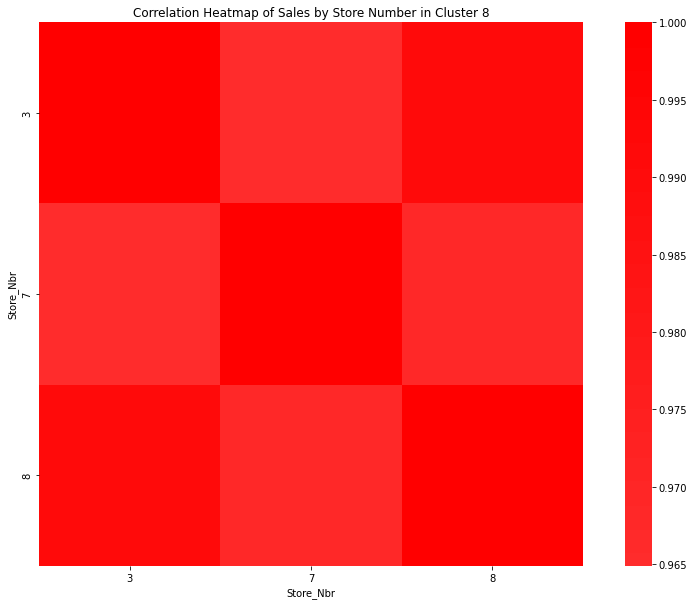

In [77]:
# Correlation between stores in a single cluster
cluster_information = (train_stores.query("cluster == 8")[['date', 'store_nbr', 'sales']].groupby(['date','store_nbr'])
                       .agg(sum)
                       .reset_index()
                       .pivot(index = 'date', columns = 'store_nbr', values = 'sales')
                       .iloc[1:].fillna(0))

plt.figure(figsize=(15,10))
sns.heatmap(cluster_information.corr(), square = True, center = 0.8, cmap = "bwr");
plt.title("Correlation Heatmap of Sales by Store Number in Cluster 8")
plt.xlabel("Store_Nbr")
plt.ylabel("Store_Nbr");

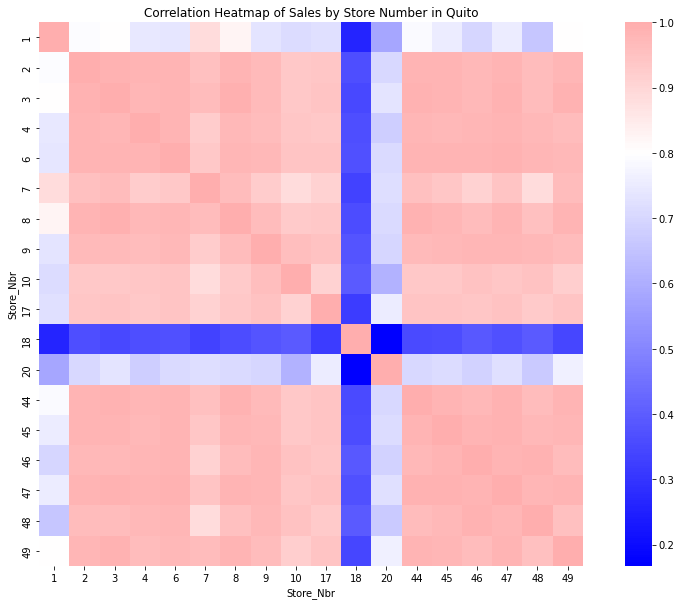

In [78]:
# Correlation between stores in a city
cluster_information = (train_stores.query("city == 'Quito'")[['date', 'store_nbr', 'sales']].groupby(['date','store_nbr'])
                       .agg(sum)
                       .reset_index()
                       .pivot(index = 'date', columns = 'store_nbr', values = 'sales')
                       .iloc[1:].fillna(0))

plt.figure(figsize=(15,10))
sns.heatmap(cluster_information.corr(), square = True, center = 0.8, cmap = "bwr");
plt.title("Correlation Heatmap of Sales by Store Number in Quito")
plt.xlabel("Store_Nbr")
plt.ylabel("Store_Nbr");

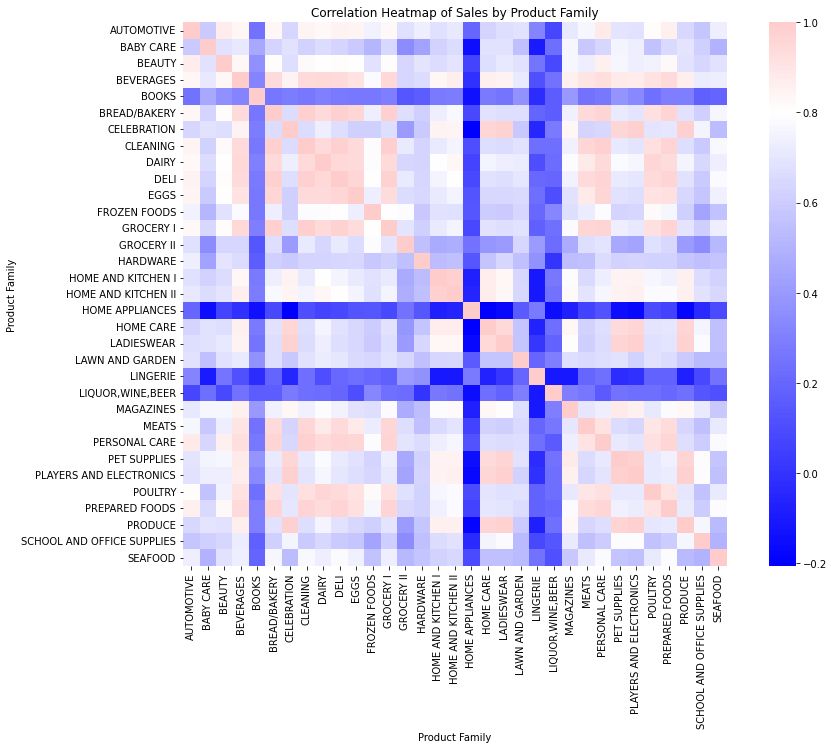

In [79]:
# code for heatmap of different families of products
cluster_information = (train[['date', 'family', 'sales']].groupby(['date','family'])
                       .agg(sum)
                       .reset_index()
                       .pivot(index = 'date', columns = 'family', values = 'sales')
                       .iloc[1:].fillna(0))

plt.figure(figsize=(15,10))
sns.heatmap(cluster_information.corr(), square = True, center = 0.8, cmap = "bwr");
plt.title("Correlation Heatmap of Sales by Product Family")
plt.xlabel("Product Family")
plt.ylabel("Product Family");

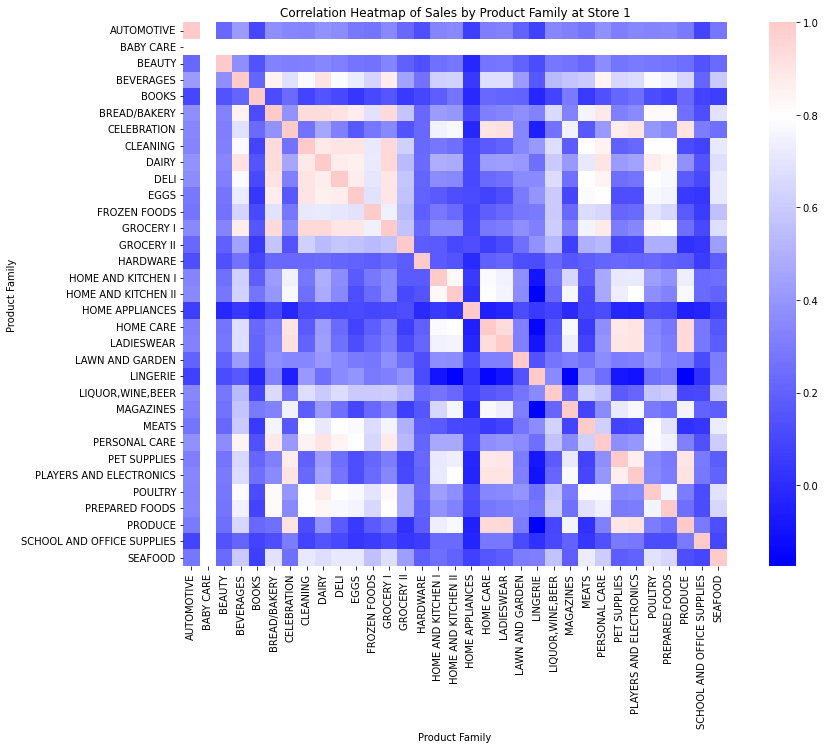

In [80]:
# code for heatmap of different families in a single store
cluster_information = (train_stores.query("store_nbr == 1")[['date', 'family', 'sales']].groupby(['date','family'])
                       .agg(sum)
                       .reset_index()
                       .pivot(index = 'date', columns = 'family', values = 'sales')
                       .iloc[1:].fillna(0))

plt.figure(figsize=(15,10))
sns.heatmap(cluster_information.corr(), square = True, center = 0.8, cmap = "bwr");
plt.title("Correlation Heatmap of Sales by Product Family at Store 1")
plt.xlabel("Product Family")
plt.ylabel("Product Family");

Periodic trends in the data can be visualized with a periodogram. Where the variance falls off can be estimated to show the period frequency that the data has. The following code was taken from Kaggle's Forecasting tutorial. Based on the example, we could take the periodicity of this data to be either monthly or bimonthly.

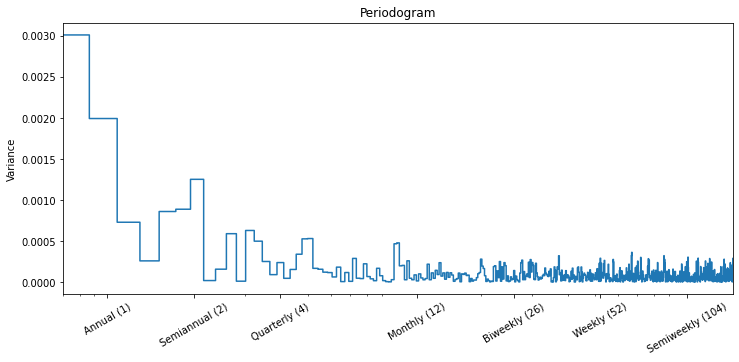

In [81]:
def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = 365
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    _, ax = plt.subplots(figsize = (12, 5))
    ax.step(freqencies, spectrum)
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.set_xlim([0.7, 150])
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

plot_periodogram(with_date.query("(store_nbr == 1) and (family == 'SCHOOL AND OFFICE SUPPLIES')")['sales']);

We can also look at the correlation of lagged data to the actual sale to see if lagged data would be used as a good predictor for the dataset. The partial autocorrelation function plotted below shows the correlation of each lag with the target (sales) and takes into control each previous lag as well. The blue shade shows the chosen level of significance and any values outside of can be considered significant.

C:\Users\noinh\AppData\Roaming\Python\Python39\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


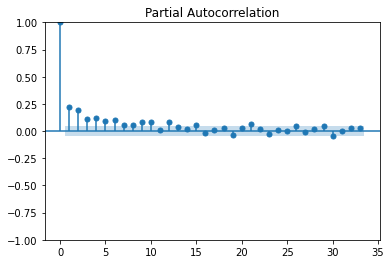

In [82]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(with_date.query("(store_nbr == 1) and (family == 'SCHOOL AND OFFICE SUPPLIES')")['sales']);

# Using Periodicity

Here we only use the date and fourier couples as features to predict the sales of each store x family. The information of the periodicity is given by the periodogram demonstrated above. However, we decide to simply use 12 fourier couples along with weekly periodicity to model our data, and use Ridge Regression to minimize the influence of unneeded features. While we are using the dataset where we filled in Christmas with 0 sales, that may negatively influence the forecasting model and may make more sense to use interpolate the data.

Side note: Although we are using the root mean-squared function to determine the error (residuals), this is technically the root mean squared log function because we are prediction the logged sales. This additionally penalizes underpredicting more than overpredicting the data.

In [83]:
def split_into_individual_datasets(dataset):
    """
    Takes in multi-time series dataframe.
    Outputs a nested dictionary with store_nbr as the first key and family as the second level key.
    
    While this isn't necessary for some machine learning algorithms and this may be quite inefficient, this is the simplest brute force way.
    """
    all_data = {}
    for i in np.arange(1,55):
        temp_dict = {}
        for family in np.sort(dataset['family'].unique()):
            temp_dict[family] = dataset.query(f"store_nbr == {i} and family == '{family}'").set_index('date').drop(labels = ['store_nbr', 'family'], axis = 1)
        all_data[i] = temp_dict
    return all_data

def dummy_holidays(data):
    return pd.get_dummies(data, columns = ['national_holiday', 'local_holiday', 'regional_holiday'])

all_data = split_into_individual_datasets(dummy_holidays(with_date))

In [84]:
import datetime

def my_rmse(actual, predicted):
    return np.sqrt(sum((actual-predicted)**2)/len(actual))

def plot_predictions(data, model):
    """
    Takes in dataframe.
    Plots y_train, y_test, y_train_predicted, y_test_predicted.
    """
    x = data.copy()
    y = x.pop('sales')
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 16, shuffle = False)
    y_train_pred = pd.Series(model.best_estimator_.predict(x_train), index = x_train.index)
    y_test_pred = pd.Series(model.best_estimator_.predict(x_test), index = x_test.index)
    
    sns.lineplot(data = np.expm1(y_train), label = 'training')
    sns.lineplot(data = np.expm1(y_train_pred), lw = 1, label = 'training_prediction')
    sns.lineplot(data = np.expm1(y_test), label = 'test')
    sns.lineplot(data = np.expm1(y_test_pred), lw = 1, label = 'test_prediction')
    #plt.ylim([0,20])
    plt.xlim([datetime.date(2017, 5, 26), datetime.date(2017, 8, 15)]);
    
def view_parameters(parameters, model):
    """
    Takes in a list of hyperparameters and model that was trained using cross validation.
    Outputs 4 scatterplots that show the hyperparameter vs mean score.
    """
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize = (10, 8))
    i, j = 0, 0
    for k in range(4):
        if i < 2:
            ax[i, j].scatter(model.cv_results_[f"param_{parameters[k]}"].data , model.cv_results_['mean_test_score'])
            ax[i, j].set_xlabel(parameters[k])
        else:
            i = 0
            j += 1
            ax[i, j].scatter(model.cv_results_[f"param_{parameters[k]}"].data , model.cv_results_['mean_test_score'])
            ax[i, j].set_xlabel(parameters[k])
        i += 1
    plt.tight_layout();

In [85]:
practice = all_data[1]['SEAFOOD'].copy()

In [86]:
from sklearn.model_selection import train_test_split, TimeSeriesSplit, RandomizedSearchCV, GridSearchCV
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from sklearn.linear_model import Ridge

def dp(data, poly):
    """
    Takes in timeseries dataframe where it is indexed by date.
    Outputs a dataframe with fourier terms and a time feature.
    """
    dp_data = DeterministicProcess(index = data.index,
                              order = poly, 
                              seasonal = True,
                              additional_terms = [CalendarFourier(freq = "A", order = 12)],
                              drop = True)
    dp_copy = dp_data.in_sample().copy()
    dp_copy['sales'] = data['sales']
    return dp_copy
    
def dp_regression(data, poly):
    """
    Outputs the dataframe outputted by statsmodel.deterministicprocess into the regression model.
    """
    return regression_model(dp(data, poly))

def regression_model(data):
    """
    Inputs the dataframe used for modelling.
    It will do a 4-fold time series cross validation and optimize for alpha for ridge regerssion.
    Outputs the trained model and the error score on the test set.
    """
    time_split = TimeSeriesSplit(n_splits = 4)
    x_train, x_test = train_test_split(data.drop(labels = 'sales', axis = 1), test_size = 16, shuffle = False)
    y_train, y_test = train_test_split(data['sales'], test_size = 16, shuffle = False)
    
    params = {'alpha': np.linspace(0.01, 100, 50),
         'solver': ['svd']}
    
    gs_cv = GridSearchCV(Ridge(), params, cv = time_split, scoring = "neg_mean_squared_error")

    return (gs_cv.fit(x_train, y_train),
            my_rmse(y_test, pd.Series(gs_cv.best_estimator_.predict(x_test), index = x_test.index)))

0.43571631746479483


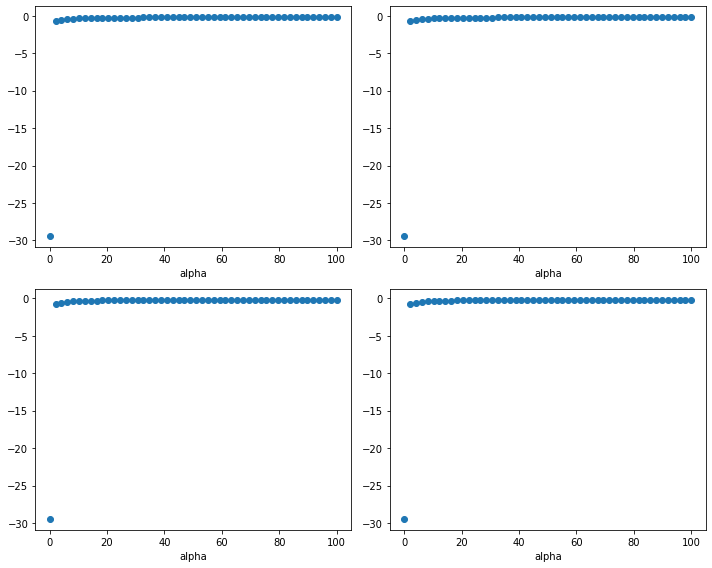

In [87]:
dprr_ml, error = dp_regression(practice, 2)
print(error)

parameters_dprr = ['alpha', 'alpha', 'alpha', 'alpha']
view_parameters(parameters_dprr, dprr_ml)

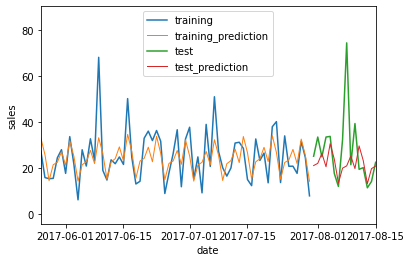

In [88]:
plot_predictions(dp(practice, 2), dprr_ml)

The engineered features will allow for a general trend + seasonal fluctuations. While the general shape of the prediction seems to follow along with the data, it seems to miss the peak and will do very poorly for datasets that have no periodicity.

# Using Lag Features

Lag features may be helpful in forecasting models if lag features have a correlation with the target value as discussed above when demonstrating the partial autocorrelation function. Here, we only use lagged values, but both periodicity and lagged values can be used together as well as other features if desired. One key consideration for the use of lagged values is the issue of data leakage. For example, if we want to forecast up to 16 days ahead, but we have a 7 day lagged value, we would either have to do an iterative prediction (which compounds on errors), or predict a constant value (which loses it's predictive power). It is also an issue for this validation test since we are simply just using the data leaked values in creating the model.

In [89]:
def make_lag_features(data, n):
    """
    Takes in timeseries dataframe.
    Outputs new dataseries with lag series given by list n.
    """
    lag_features = pd.concat({f'y_lag_{i}': practice['sales'].shift(i, fill_value = 0) for i in n}, axis = 1)
    lag_features['sales'] = data['sales']
    ## Here it might also make sense to add other features like moving averages
    return lag_features

def lag_regression(data):
    """
    Outputs the dataframe with lag features into the regression model.
    """
    lags = [7, 14, 28, 60]
    return regression_model(make_lag_features(data, lags))

make_lag_features(practice, n = [7, 14, 28, 60])

,y_lag_7,y_lag_14,y_lag_28,y_lag_60,sales
date,,,,,
2013-01-01,0.000000,0.000000,0.000000,0.000000,0.000000
2013-01-02,0.000000,0.000000,0.000000,0.000000,3.664305
2013-01-03,0.000000,0.000000,0.000000,0.000000,2.910501
2013-01-04,0.000000,0.000000,0.000000,0.000000,3.430983
2013-01-05,0.000000,0.000000,0.000000,0.000000,3.252001
...,...,...,...,...,...
2017-08-11,3.548697,3.484895,3.386591,3.201241,3.016711
2017-08-12,2.924505,3.240755,2.771338,3.129564,3.051640
2017-08-13,2.561482,2.182900,2.588816,3.251382,2.515921


0.42221599442840735


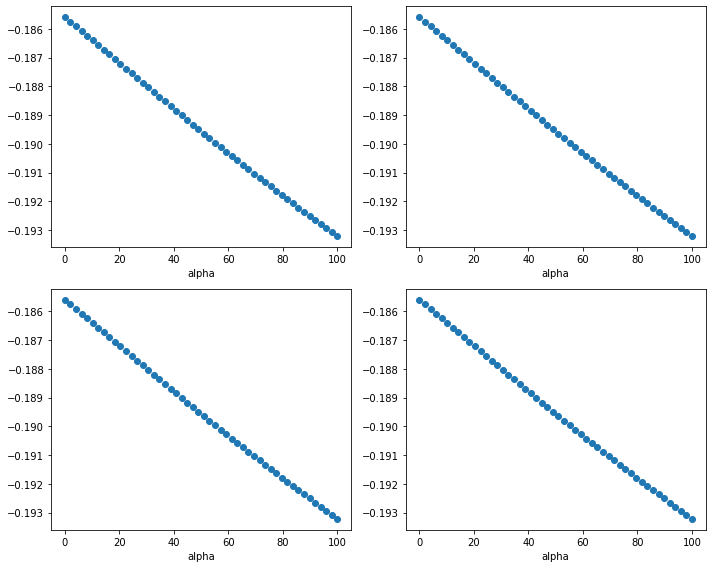

In [90]:
lrr_ml, error = lag_regression(practice)
print(error)

parameters_lrr = ['alpha', 'alpha', 'alpha', 'alpha']
view_parameters(parameters_lrr, lrr_ml)

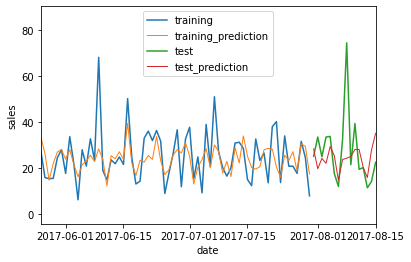

In [91]:
plot_predictions(make_lag_features(practice, [7, 14, 28, 60]), lrr_ml)

# Using Numerical Seasonality Variables (Boosted Trees)

We could additionally use boosted decision trees as our forecasting model as well. Rather than relying on sinusoidal periodicity, we can simple use created numerical variables. While decision trees are not good for extrapolation, for a 16 day forecast, that is not an issue. A big issue with this approach is that these boosted tree algorithms are quite computationally costly. For only searching through 10 hyperparameters per model on a 3-fold split, it'll require a total of 53460 models to be trained. 

In [92]:
practice2 = all_data[1]['SEAFOOD'][['sales', 'onpromotion', 'year', 'month', 'day_week', 'day']]

In [93]:
from xgboost import XGBRegressor

def boosted_tree_modeler(model, params, data, iterations):
    """
    The general function for modeling using boosted trees.
    Inputs the type of model, the parameters to optimize, the dataframe, and how many iterations of parameters to try.
    Outputs trained model and error score of test.
    """
    time_split = TimeSeriesSplit(n_splits = 3)
    x_train, x_test = train_test_split(data, test_size = 16, shuffle = False)
    y_train = x_train.pop('sales')
    y_test = x_test.pop('sales')
    
    rcv = RandomizedSearchCV(model, params, cv = time_split, 
                            scoring = 'neg_mean_squared_error', n_iter = iterations)
    
    return (rcv.fit(x_train, y_train),
            my_rmse(y_test, pd.Series(rcv.best_estimator_.predict(x_test), index = x_test.index)))
    
def xgb_modeler(data):
    """
    Takes in timeseries dataframe.
    Outputs the data and parameters into the boosted tree modeler.
    """
    xgb_params = {'n_estimators': [500],
               'max_depth': [8],
               'eta': [0.6, 0.8, 1],
                 'min_child_weight' : [0.15],
                 'subsample' : [0.6, 0.8, 1],
                 'alpha' : np.linspace(0.01, 6, 5),
                 'gamma' : [16],
                 'n_jobs' : [-1]}
    
    return boosted_tree_modeler(XGBRegressor(), xgb_params, data, 10)

0.3941330556981641


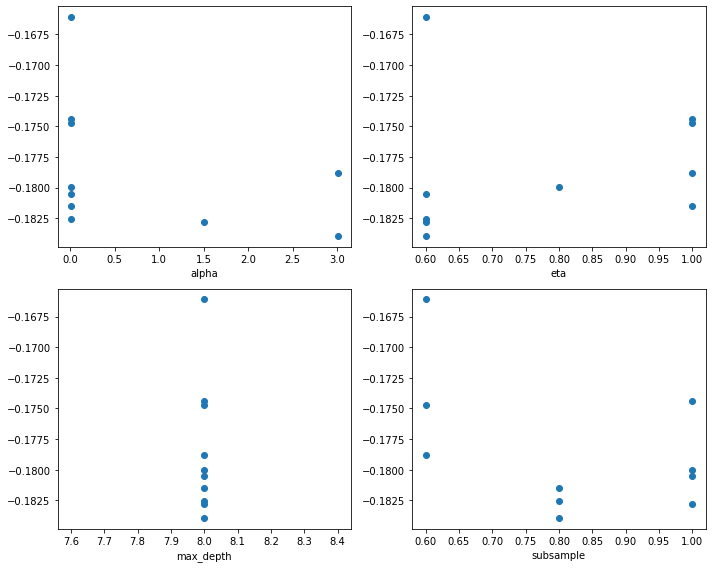

In [94]:
xgb_ml, error = xgb_modeler(practice2)
print(error)

parameters_xg = ['alpha', 'max_depth', 'eta', 'subsample']
view_parameters(parameters_xg, xgb_ml)

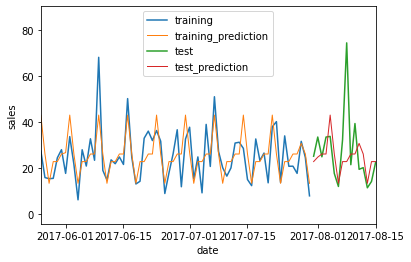

In [95]:
plot_predictions(practice2, xgb_ml)

In [96]:
from lightgbm import LGBMRegressor

def lgbm_modeler(data):
    """
    Takes in timeseries dataframe.
    Outputs the data and parameters into the boosted tree modeler.
    """
    lgbm_params = {'n_estimators': [500],
                   'n_jobs': [-1],
                   'num_leaves' : [20],
                   'max_depth': [8],
                   'learning_rate': [0.1, 0.6, 1],
                   'min_child_samples' : [45, 60],
                   'colsample_bytree' : [0.8, 0.9],
                  'reg_lambda': [0.1, 10, 100]}
    
    return boosted_tree_modeler(LGBMRegressor(), lgbm_params, data, 20)

0.465212084059479


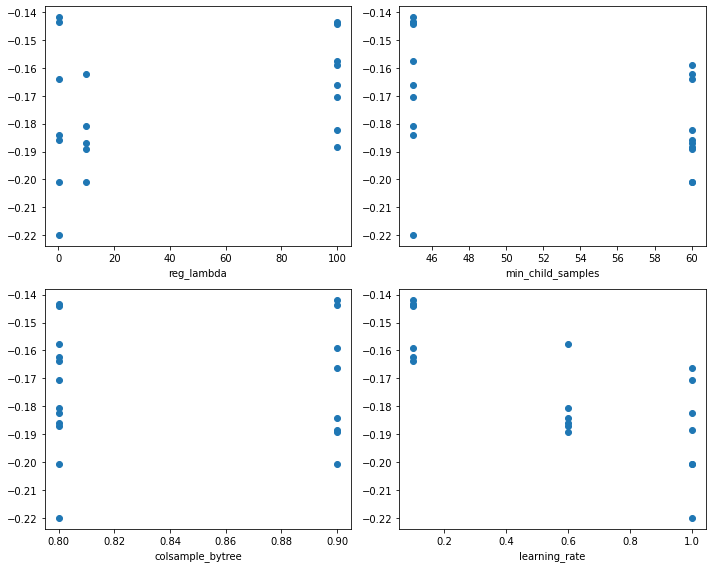

In [97]:
lgbm_ml, error = lgbm_modeler(practice2)
print(error)

parameters_lg = ['reg_lambda', 'colsample_bytree', 'min_child_samples', 'learning_rate']
view_parameters(parameters_lg, lgbm_ml)

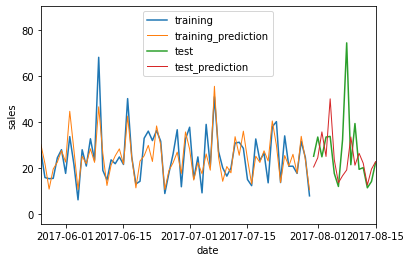

In [98]:
plot_predictions(practice2, lgbm_ml)

# Using Exponential Smoothing (Darts)

A common approach for forecasting time series is to use ARIMA or SES. This only takes in one variable (the target variable) and uses the last data point or a weighted section of recent data points to predict future values. This approach is useful when the data does not have periodicity, but it cannot predict sharp spikes in data. The following code was inspired by this Kaggle notebook: .

In [99]:
from darts import TimeSeries
from darts.models import ExponentialSmoothing
from darts.metrics import rmse, rmsle
from darts.timeseries import concatenate

def ES_modeler(data):
    """
    Takes in timeseries dataframe.
    Uses DARTS library to do exponential smoothing.
    Returns model and test score.
    """
    darts_series = TimeSeries.from_dataframe(data, value_cols = 'sales')
    train_darts, test_darts = darts_series[:-16], darts_series[-16:]

    ES = ExponentialSmoothing()
    
    return (ES.fit(train_darts), rmse(test_darts, ES.predict(16)))

0.4470084076081434


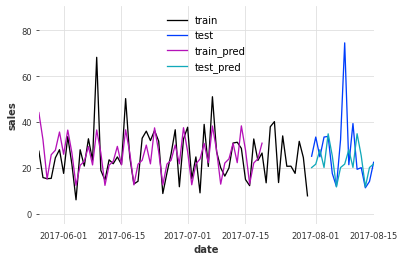

In [100]:
ES, error = ES_modeler(practice)
print(error)

backtest_series_ES = ES.historical_forecasts(
    TimeSeries.from_dataframe(practice, value_cols = 'sales')[:-16],
    start=pd.Timestamp('20170501'),
    forecast_horizon=16,
    stride=16,
    last_points_only=False,
)

predicted_ES = ES.predict(16)

sns.lineplot(data = np.expm1(practice['sales'][:-16]), label = 'train')
sns.lineplot(data = np.expm1(practice['sales'][-16:]), label = 'test')
sns.lineplot(data = np.expm1(concatenate(backtest_series_ES).pd_series()), label = 'train_pred')
sns.lineplot(data = np.expm1(predicted_ES.pd_series()), label = 'test_pred')
plt.ylim()
plt.xlim([datetime.date(2017, 5, 26), datetime.date(2017, 8, 15)]);

# Making Predictions

As with all data analytics/modeling, it is of primary importance to understand the purpose and context of the work. This Kaggle dataset/competition is based off a previous competition for a large grocery chain in Ecuador to make the best model based on a 16 day forecast. If the primary goal is simply to make the best 16 day forecast for the last half of August, then a lot of the data doesn't have to be used. If the goal is to have a continuous forecasting model for the sake of large scale inventory planning, it would be better to use all the data (probably). If the goal is for overall sales and to check productivity or success in sales tactics, then it might not be needed to model as intricately.

Likely domain knowledge from the local managers of each store can help facilitate much of the modeling better for individual stores. However, on a large corporation front, it may be a waste of resources to model all the individual store x family sales.

In [101]:
def load_process_data_numerical(data_path, i = 1, use_holidays = False):
    """
    Overall pipeline for data processing to use in model.
    Inputs datapath for either training or testing data, an int i (0 for test, 1 for train), and whether to use holiday features.
    Outputs formatted dataframe in a nested dictionary.
    """
    data = pd.read_csv(data_path, usecols = range(i, 5+i) , parse_dates = ['date']).pipe(add_date_features)
    if i == 1:
        data['sales'] = np.log1p(data['sales'])
    if use_holidays:
        data = (data.pipe(add_store_information, stores)
            .pipe(add_holidays, national, local, regional)
            .pipe(dummy_holidays))
    return split_into_individual_datasets(data)

def add_missing_columns(train, test):
    """
    If columns are in train that are not in test, add those columns with values filled with zeroes.
    """
    for column in train.columns:
        if column not in test.columns:
            test[column] = 0
    return test[train.columns]

def train_model(training_data, model):
    """
    Takes in nested dictionary of training data and type of model to train.
    Trains each time series independently and outputs a nested dictionary in the same hierarchical structure.
    The values are tuples in the form (model, validation error).
    """
    all_models = {}
    for store in training_data:
        temp_dict = {}
        for family in training_data[store]:
            if sum(training_data[store][family].last("365D")['sales']) == 0:
                temp_dict[family] = False
            else:
                temp_dict[family] = model(training_data[store][family])
        all_models[store] = temp_dict
        if store % 10 == 0:
            print(store)
    return all_models

def predict_test(train_data, test_data, models):
    """
    Takes in the nested dictionaries of training data, test data, and trained models.
    Predicts the values using test data using all the trained models.
    Outputs a single series with all the predicted values.
    """
    predictions = []
    for store in models:
        for family in models[store]:
            id_column = test_data[store][family].pop('id')
            if models[store][family] == False:
                prediction = pd.Series(np.zeros(16), index = id_column)
            else:
                i_model = models[store][family][0]
                testing_data = add_missing_columns(train_data[store][family].drop(labels = 'sales', axis = 1), test_data[store][family])
                prediction = pd.Series(np.expm1(i_model.predict(testing_data)), index = id_column)
            predictions.append(prediction)
    return pd.concat(predictions).sort_index()

def load_model_predict_submit(model, name, holidays = False):
    """
    Inputs model type, name for csv file, and whether to use holidays.
    Loads, trains, predicts, and saves file onto computer for submission.
    """
    train = load_process_data_numerical('train.csv', i = 1, use_holidays = holidays)
    test = load_process_data_numerical('test.csv', i = 0, use_holidays = holidays)
    models = train_model(train, model)
    submission = predict_test(train, test, models)
    submission.name = 'sales'
    submission.to_csv(f"{name}_holidays.csv")

Test needs to have [['onpromotion', 'year', 'month', 'day_week', 'day']] as the columns. Test will also be separated into a dictionary and if model isn't false, it will model it using the corresponding model and use the id as the new index of the prediction. After each prediction, it will concatenate it to a single dataframe, and then sort by id for submission.

In [83]:
# XGBoost with Holidays
load_model_predict_submit(xgb_modeler, 'xgb_withholidays', holidays = True)

10
20
30
40
50


In [84]:
# XGBoost without Holidays
load_model_predict_submit(xgb_modeler, 'xgb_noholidays', holidays = False)

10
20
30
40
50


In [85]:
# LGBM without Holidays
load_model_predict_submit(lgbm_modeler, 'lgbm_noholidays', holidays = False)

10
20
30
40
50


In [413]:
def predict_darts_test(train_data, test_data, models):
    """
    Takes in timeseries dataframe.
    Outputs the data and parameters into the boosted tree modeler.
    """
    predictions = []
    for store in models:
        for family in models[store]:
            id_column = test_data[store][family].pop('id')
            if models[store][family] == False:
                prediction = pd.Series(np.zeros(16), index = id_column)
            else:
                i_model = models[store][family][0]
                prediction = np.expm1(i_model.predict(32).pd_series()[-16:])
                prediction = prediction.set_axis(id_column)
            predictions.append(prediction)
    return pd.concat(predictions).sort_index()

In [414]:
test = load_process_data_numerical('test.csv', i = 0)
darts_models = train_model(all_data, ES_modeler)
darts_submission = predict_darts_test(all_data, test, darts_models)
darts_submission.name = 'sales'
darts_submission.to_csv("darts_ES.csv")

While neural networks and hybrid models have not been explored here, they are likely to yield more accurate forecasts rather than relying on boosted trees or exponential smoothing models. Out of the predictions we made here, ___ produced the model with the highest score, putting this model on the top __% of the models of submitted predictions on Kaggle.